<a href="https://colab.research.google.com/github/pinnouse/zeroshot-unsupervised-mt/blob/main/CSC413_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install apache_beam mwparserfromhell
!pip install transformers
!pip install datasets
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

# multilingual CLIP pretrained
# https://github.com/FreddeFrallan/Multilingual-CLIP
!pip install multilingual-clip
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.5/515.5 kB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 24.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for crcmod: filename=crcmod-1.7-cp39-cp39-linux_x86_64.whl size=36925 sha256=cb49c41a84d591ea16b0713afa8801508c02ec246

# Data Processing

In [ ]:
from datasets import load_dataset
import random

dataset = load_dataset("wikipedia", "20220301.simple")
dataset_fr = load_dataset("wikipedia", "20220301.fr")
dataset_swahili = load_dataset("wikipedia", "20220301.sw")

training_percent = 0.8
validation_percent = 0.1
testing_percent = 0.1

# english
ds_en_len = len(dataset)
test_index_en = ds_en_len * training_percent
valid_index_en = ds_en_len * (training_percent + validation_percent)

# start to test index
test_data_en = dataset['train'][: int(test_index_en)]
# test index to validation index
validation_data_en = dataset['train'][int(test_index_en):int(valid_index_en)]
# validation index to end
test_data_en = dataset['train'][int(valid_index_en):]

# french
ds_fr_len = len(dataset_fr)
test_index_fr = ds_fr_len * training_percent
valid_index_fr = ds_fr_len * (training_percent + validation_percent)

# start to test index
test_data_fr = dataset['train'][: int(test_index_fr)]
# test index to validation index
validation_data_fr = dataset['train'][int(test_index_fr):int(valid_index_fr)]
# validation index to end
test_data_fr = dataset['train'][int(valid_index_fr):]

def batch_loader(dataset, batch_size, shuffle=True):
  text = dataset['train']['text']

  if shuffle:
    random.shuffle(text)

  data_batch = []

  for i in range((len(text) // batch_size)):
    data_batch.append(text[i * batch_size:(i + 1) * batch_size])

  if len(text) % batch_size != 0:
    data_batch.append(text[(len(text) // batch_size) * batch_size:])
  
  return data_batch

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/235M [00:00<?, ?B/s]

Dataset wikipedia downloaded and prepared to /root/.cache/huggingface/datasets/wikipedia/20220301.simple/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/4.33k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/7.38G [00:00<?, ?B/s]

Dataset wikipedia downloaded and prepared to /root/.cache/huggingface/datasets/wikipedia/20220301.fr/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [ ]:
text = map(lambda x: x['text'].replace("\n", ' ').split(". "), dataset['train'])
text_long = []
for t in text:
  for s in t:
    text_long.append(s) 
print(text_long[0])

April is the fourth month of the year in the Julian and Gregorian calendars, and comes between March and May


In [ ]:
text_fr = map(lambda x: x['text'].replace("\n", ' ').split(". "), dataset_fr['train'])
for t in text_fr:
  print(t)
  break

['Paul Jules Antoine Meillet, né le  à Moulins (Allier) et mort le  à Châteaumeillant (Cher), est le principal linguiste français des premières décennies du ', 'Il est aussi philologue', " Biographie  D'origine bourbonnaise, fils d'un notaire de Châteaumeillant (Cher), Antoine Meillet fait ses études secondaires au lycée de Moulins", " Étudiant à la faculté des lettres de Paris à partir de 1885 où il suit notamment les cours de Louis Havet, il assiste également à ceux de Michel Bréal au Collège de France et de Ferdinand de Saussure à l'École pratique des hautes études", " En 1889, il est major de l'agrégation de grammaire", " Il assure à la suite de Saussure le cours de grammaire comparée, qu'il complète à partir de 1894 par une conférence sur les langues persanes", " En 1897, il soutient sa thèse pour le doctorat ès lettres (Recherches sur l'emploi du génitif-accusatif en vieux-slave)", "En 1905, il occupe la chaire de grammaire comparée au Collège de France, où il consacre ses cours 

In [ ]:
import torch
import torchtext
import clip
import numpy as np
from sentence_transformers import SentenceTransformer, util

device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load("ViT-B/32", device=device)

text_model = SentenceTransformer('sentence-transformers/clip-ViT-B-32-multilingual-v1',
                                 device=device)

context_length = 64
#glove = torchtext.vocab.GloVe(name="6B", dim=50)
#ft = torchtext.vocab.FastText(language="simple")

Tokenize/Embbed English data

In [ ]:
train_data_en = []
for (i, t) in enumerate(text_long):
  if i > 5:
    break
  tokenized = tokenizer(t, padding='max_length', max_length=64, return_tensors='pt').input_ids[0] #took 18 mins to run
  if len(tokenized) <= 64:
    sentences = []
    for s in range(len(tokenized)):
      sentences.append(tokenizer.decode(tokenized[1:s], skip_special_tokens=True))
    #[bs x 64 x 512]
    clips = text_model.encode(sentences)
    train_data_en.append((t,clips,tokenized.to(device)))

Tokenize/Embbed French data

In [ ]:
train_data_fr = []

for (i, t) in enumerate(text_fr):
  if i > 5:
    break
  sentence = t[0]
  if len(sentence.split(' ')) > 60:
    continue
  tokenized = tokenizer(sentence, padding='max_length', max_length=64, return_tensors='pt')['input_ids'][0]
  # tokenized = tokenized.to(device)
  train_data_fr.append((sentence, tokenized.to(device)))

# GAN+Autoencoder Idea
![Diagram](https://media.discordapp.net/attachments/1085342382679138385/1090810686793318491/image.png?width=1440&height=592)
Orange represents the zeroshot translation task

## Define Models

We will create 4 models:
1. Monolingual generator (expert at i.e. FR, DE) - transformer encoder+decoder
2. CLIP Embedding Decoder - transformer decoders
3. Discriminator - linear neural network (subject to change)
4. Translator - two linear parts from embedding space to embedding space (thought of as a transform function from FR -> EN, and the inverse EN -> FR)

We refer to 2 agents that are learning to understand their respective languages, both represented by transformers.
`Base expert` is the agent that 'understands' English (from CLIP).
`Other expert` is agent that is an expert of the other language.

In [ ]:
 from torch import nn
from torch import Tensor
import math

# https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
  def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout)

    position = torch.arange(max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
    pe = torch.zeros(max_len, 1, d_model)
    pe[:, 0, 0::2] = torch.sin(position * div_term)
    pe[:, 0, 1::2] = torch.cos(position * div_term)
    self.register_buffer('pe', pe)

  def forward(self, x: Tensor) -> Tensor:
    """
    Args:
        x: Tensor, shape [seq_len, batch_size, embedding_dim]
    """
    x = x + self.pe[:x.size(0)]
    return self.dropout(x)

# https://jamesmccaffrey.wordpress.com/2022/09/09/simplest-transformer-seq-to-seq-example/
class Transformer(nn.Module): # same language/monolingual
  def __init__(self, ntoken: int, d_model: int = 512, nhead: int = 4, d_hid: int = 512,
               nlayers: int = 4, dropout: float = 0.5):
    super().__init__()

    self.model_type = 'Transformer'

    self.embed = nn.Embedding(ntoken, d_model)

    self.pos_enc = PositionalEncoding(d_model, dropout)
    encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_hid, dropout,
                                                batch_first=True)
    self.encoder = nn.TransformerEncoder(encoder_layers, nlayers)

    decoder_layers = nn.TransformerDecoderLayer(d_model, nhead, d_hid, dropout,
                                                batch_first=True)
    self.decoder = nn.TransformerDecoder(decoder_layers, nlayers)

    self.d_model = d_model

    self.dense = nn.Linear(d_model, ntoken)

    self.init_weights()

  def init_weights(self) -> None:
    initrange = 0.1
    self.dense.weight.data.uniform_(-initrange, initrange)
    self.dense.bias.data.zero_()

  def forward(self, src, tgt, tgt_mask, tp_mask=None, sp_mask=None):
    s = self.embed(src)
    t = self.embed(tgt)

    s = self.pos_enc(s)
    t = self.pos_enc(t)

    e = self.encoder(s, src_key_padding_mask=sp_mask)
    d = self.decoder(t, e, tgt_mask=tgt_mask, tgt_key_padding_mask=tp_mask, memory_key_padding_mask=sp_mask)
    z = self.dense(d)
    # z = nn.functional.softmax(z, dim=2)
    return z, e

  def encode(self, src, sp_mask=None):
    s = self.embed(src)
    s = self.pos_enc(s)
    e = self.encoder(s, src_key_padding_mask=sp_mask)
    return e

class Translator(nn.Module):
  def __init__(self, i_embed_size = 512, o_embed_size = 512, nlayers = 1, hidden = 1024):
    super().__init__()
    
    # based off https://arxiv.org/abs/1809.03633
    self.G = nn.Sequential(nn.Linear(i_embed_size, hidden))
    self.F = nn.Sequential(nn.Linear(o_embed_size, hidden))
    for i in range(nlayers-1):
      self.G.append(nn.Linear(hidden, hidden))
      self.F.append(nn.Linear(hidden, hidden))
    self.G.append(nn.Linear(hidden, o_embed_size))
    self.F.append(nn.Linear(hidden, i_embed_size))

  def forward(self, i_emb):
    o = self.G(i_emb)
    i = self.F(o)
    return o, i
  
class Decoder(nn.Module):
  def __init__(self, ntoken: int, d_model: int = 512, nhead: int = 4, d_hid: int = 512,
               dropout: float = 0.5, nlayers: int = 4):
    super().__init__()
    self.embed = nn.Embedding(ntoken, d_model)
    self.pos_enc = PositionalEncoding(d_model, dropout)

    decoder_layers = nn.TransformerDecoderLayer(d_model, nhead, d_hid, dropout,
                                                batch_first=True)
    self.decoder = nn.TransformerDecoder(decoder_layers, nlayers)
    self.dense = nn.Linear(d_model, ntoken)
  
  def forward(self, enc, tgt, tgt_mask):
    t = self.embed(tgt)
    t = self.pos_enc(t)

    d = self.decoder(t, enc, tgt_mask=tgt_mask)
    z = self.dense(d)
    return z
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(512, 100),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(100, 1),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.model(x)
        return out.view(x.size(0))

## Train Loop

PyTorch training for GAN:
[PyTorch blog](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

In [ ]:
print(tokenizer.vocab_size)
real_decoder = Decoder(tokenizer.vocab_size)
transformer = Transformer(tokenizer.vocab_size) # temp vocab size
translate = Translator(hidden=512)
discriminator = Discriminator()

real_decoder.to(device)
transformer.to(device)
translate.to(device)
discriminator.to(device)

119547


Discriminator(
  (model): Sequential(
    (0): Linear(in_features=512, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

("L’algèbre linéaire est la branche des mathématiques qui s'intéresse aux espaces vectoriels et aux transformations linéaires, formalisation générale des théories des systèmes d'équations linéaires", tensor([  101,   149,   100, 10164, 10240, 13340, 13724, 11614, 11246, 16556,
        10176, 10109, 58760, 10139, 71777, 10355,   187,   112, 26391, 20017,
        12818, 10754, 84355, 46514, 19428, 10107, 10131, 10754, 44510, 10107,
        11614, 11246, 29194,   117, 23129, 20312, 28274, 10139, 38914, 10107,
        10139, 48273,   172,   112,   263, 32973, 15024, 11614, 11246, 29194,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0], device='cuda:0'))
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Epoch 1:


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


	train loss (decoder)   : 0.11261320114135742
	train loss (generator) : 0.045172639191150665
	train loss (discrim)   : 0.0029248371720314026
	train loss (translator): 0.0003937671717721969
	took: 0.643282 seconds
Epoch 2:
	train loss (decoder)   : 0.11436402052640915
	train loss (generator) : 0.09641090035438538
	train loss (discrim)   : 0.0026256199926137924
	train loss (translator): 0.0003472926910035312
	took: 0.696091 seconds
Epoch 3:
	train loss (decoder)   : 0.11275860667228699
	train loss (generator) : 0.11707045882940292
	train loss (discrim)   : 0.0024344888515770435
	train loss (translator): 0.0003747942391782999
	took: 0.592342 seconds
Epoch 4:
	train loss (decoder)   : 0.10536080598831177
	train loss (generator) : 0.13133063912391663
	train loss (discrim)   : 0.0021367736626416445
	train loss (translator): 0.0002957336837425828
	took: 0.622852 seconds
Epoch 5:
	train loss (decoder)   : 0.13265210390090942
	train loss (generator) : 0.09399819374084473
	train loss (discrim)  

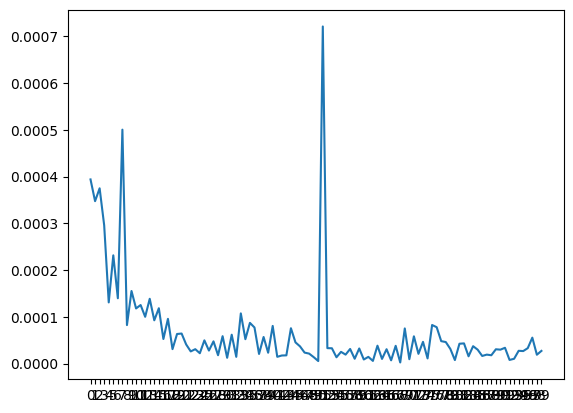

In [ ]:
from torch import optim
# https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#transformers.Adafactor
from transformers.optimization import Adafactor
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import drive

context_length = 64

# TODO: add device specific code

def pad(tokens, context_length):
  l = list(tokens)
  for _ in range(context_length - len(tokens)):
    l.append(tokenizer.pad_token_id)
  return np.array(l)

def train(real_decoder, transformer, discriminator, translate, # our four models
          real_train, other_train, real_valid = None, other_valid = None, device = 'cpu',
          epochs = 10, batch_size = 256, ckpt_path = None, ckpt_interval = 10):
  batch_data = []

  # yash
  data_loader = [(real_train, other_train)]

  criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
  criterion_binary = nn.BCEWithLogitsLoss()
  mse = nn.MSELoss()

  # r_optim = optim.RAdam(real_decoder.parameters())
  # g_optim = optim.RAdam(generator.parameters())
  r_optim = Adafactor(real_decoder.parameters())
  g_optim = Adafactor(transformer.parameters())
  t_optim = Adafactor(translate.parameters())
  d_optim = Adafactor(discriminator.parameters())

  r_iterations = len(real_train) // batch_size
  o_iterations = len(other_train) // batch_size
  # r_iterations = real_train.shape[0] // batch_size
  # o_iterations = other_train.shape[0] // batch_size

  n = min(r_iterations, o_iterations)

  losses = []

  for e in range(epochs):
    r_epoch_loss = 0
    g_epoch_loss = 0
    d_epoch_loss = 0
    t_epoch_loss = 0
    # yash (every epoch: shuffle)
    # data_loader = batcherize(train_data)
    # data_loader.shuffle()
    # random.shuffle(batches of the dataloader)
    epoch_start = datetime.now()
    print(f'Epoch {e+1}:')
    for i, (r_x, o_x) in enumerate(data_loader):
      # r_x: (english sentence: str, CLIP embeddings: float[512], tokens: one-hots[num tokens])[batch_size]
      # o_x: (fr sentence: str, tokens: one-hot[num tokens])[batch_size]
      # if r_x.shape[0] < batch_size: # not full batch
      #   break
      if (i + 1) % 100 == 0:
        print(f'Iteration {i+1} of {n}')

      n_r = len(r_x)
      n_o = len(o_x)

      rx_clips = torch.tensor(np.array(list(map(lambda x: x[1], r_x))), device=device)
      rx_toks = torch.tensor(np.array(list(map(lambda x: x[2].numpy(force=True), r_x))), device=device)
      ox_toks = torch.tensor(np.array(list(map(lambda x: x[1].numpy(force=True), o_x))), device=device)

      # ==============================
      # == learn decoder
      # ==============================
      tgt_in = rx_toks[:, :-1]
      tgt_expect = rx_toks[:, 1:]
      r_mask = nn.Transformer.generate_square_subsequent_mask(context_length - 1, device=device)
      r_output = real_decoder(rx_clips, tgt_in, tgt_mask=r_mask)
      r_output = r_output.permute(0,2,1)
      r_loss = criterion(r_output, tgt_expect)
      r_epoch_loss += r_loss.item()

      r_optim.zero_grad()
      r_loss.backward(retain_graph=True)
      r_optim.step()

      # ==============================
      # == self learn monolingual
      # ==============================
      # "other" generator self supervised
      # https://jamesmccaffrey.wordpress.com/2022/09/09/simplest-transformer-seq-to-seq-example/
      
      src = ox_toks
      tgt = src
      tgt_in = tgt[:,:-1]
      tgt_expect = tgt[:,1:]
      t_mask = nn.Transformer.generate_square_subsequent_mask(context_length - 1, device=device)
      # https://pytorch.org/tutorials/beginner/translation_transformer.html#seq2seq-network-using-transformer
      tgt_attn_mask = (tgt_in == tokenizer.pad_token_id)
      attn_mask = (src == tokenizer.pad_token_id)

      output, other_embeddings = transformer(src, tgt_in, tgt_mask=t_mask, tp_mask=tgt_attn_mask, sp_mask=attn_mask) # [bs,seq,vocab]

      # get preds shape to conform to tgt_expect
      output = output.permute(0,2,1)  # now [bs, vocab, seq]

      g_loss = criterion(output, tgt_expect)
      g_epoch_loss += g_loss.item()

      g_optim.zero_grad()
      g_loss.backward(retain_graph=True)
      g_optim.step()

      # ==============================
      # == learn discriminator
      # ==============================
      fake_embs, F_embs = translate(other_embeddings[:,-1,:])
      real_embs = rx_clips[:,-1,:]
      inputs = torch.cat([real_embs, fake_embs])
      reals = torch.ones(n_r, device=device) #whatever batch_sizes will be
      fakes = torch.zeros(n_o, device=device) # ^^
      labels = torch.cat([reals,fakes]) #[n_1 + n_2,512]

      d_outputs = discriminator(inputs) 
      d_loss = criterion_binary(d_outputs, labels)
      d_epoch_loss += d_loss.item()
      d_optim.zero_grad()
      d_loss.backward(retain_graph=True)
      d_optim.step()

      # ==============================
      # == learn translator
      # ==============================
      
      t_outputs = discriminator(fake_embs)
      t_loss = criterion_binary(t_outputs, fakes)
      tl_loss = mse(F_embs, other_embeddings[:,-1,:]) # "cycle GAN" reconstruct fr embeddings
      t_epoch_loss += t_loss.item()
      t_optim.zero_grad()
      t_loss.backward(retain_graph=True)
      tl_loss.backward()
      t_optim.step()


    print(f'\ttrain loss (decoder)   : {r_epoch_loss}')
    print(f'\ttrain loss (generator) : {g_epoch_loss}')
    print(f'\ttrain loss (discrim)   : {d_epoch_loss}')
    print(f'\ttrain loss (translator): {t_epoch_loss}')
    print(f'\ttook: {(datetime.now() - epoch_start).total_seconds()} seconds')
    losses.append(t_epoch_loss)
    if ckpt_path is not None and e % ckpt_interval == 0:
      state = {
          'real_decoder_state': real_decoder.state_dict(),
          'real_decoder_loss': r_epoch_loss,
          'transformer_state': transformer.state_dict(),
          'transformer_loss': t_epoch_loss,
          'discriminator_state': discriminator.state_dict(),
          'discriminator_loss': d_epoch_loss,
          'translate_state': translate.state_dict(),
          'translate_loss': t_epoch_loss,
      }
      torch.save(state, ckpt_path + f'/ckpt-epoch-{e}.pt')
  # plt.xticks(np.arange(epochs))
  plt.plot(losses)
  plt.show()

print(train_data_fr[0])
# To disable checkpointing, comment the next two lines and remove the ckpt_path
# parameter in the call to train().
drive.mount('/content/gdrive')
ckpt_path = '/content/gdrive/My Drive/CSC413/Project/'
train(real_decoder, transformer, discriminator, translate, [train_data_en[0]] * 2, [train_data_fr[0]] * 16, epochs=100, device=device, ckpt_path=ckpt_path)
# train(real_decoder, transformer, discriminator, translate, train_data_en, train_data_fr, epochs=100, ckpt_path=ckpt_path)

### Overfit Inference

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
ckpt_path = '/content/gdrive/My Drive/CSC413/Project/ckpt-epoch-90.pt'
checkpoint = torch.load(ckpt_path)

real_decoder.load_state_dict(checkpoint['real_decoder_state'])
transformer.load_state_dict(checkpoint['transformer_state'])
translate.load_state_dict(checkpoint['translate_state'])
# discriminator.load_state_dict(checkpoint['discriminator'])

real_decoder.eval()
transformer.eval()
translate.eval()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Translator(
  (G): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
  )
  (F): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
  )
)

In [ ]:
x = train_data_fr[0]
print(f'input: {x}')
xx = torch.tensor(np.array([x[1].numpy()]))
sp = (xx == tokenizer.pad_token_id)
embs = transformer.encode(xx, sp_mask=sp)
en_embs, _ = translate(embs[:,-1:])

print('='*26)
s = [tokenizer.cls_token_id]
for i in range(30):
  seq = torch.tensor(np.array([s]))
  t_mask = nn.Transformer.generate_square_subsequent_mask(i + 1)
  o = real_decoder(en_embs[:,-1:], seq, t_mask)
  m = torch.argmax(o, dim=2)
  tk = m[0, -1]
  s.append(tk)
  print(tokenizer.decode(s))
  if tk == tokenizer.eos_token_id:
    break

input: ('Arsène Lupin est un personnage de fiction français créé par Maurice Leblanc', tensor([  101, 64304, 18105, 23859, 17298, 10176, 10119, 28601, 10104, 20455,
        12501, 23673, 10248, 15560, 10281, 22491, 29420,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]))
[CLS] April
[CLS] April is
[CLS] April is the
[CLS] April is the fourth
[CLS] April is the fourth month
[CLS] April is the fourth month of
[CLS] April is the fourth month of the
[CLS] April is the fourth month of the year
[CLS] April is the fourth month of the year in
[CLS] April is the fourth month of the year in the
[CLS] April is the fourth month of the year in the Julian
[CLS] April is the fourth mon